In [11]:
# For data handling and numerical operations
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set some visualization styles
sns.set_style('whitegrid')

In [12]:
# Load the dataset
df = pd.read_csv('Fraud.csv')

# Display the first few rows
print(df.head())

# Get a concise summary of the dataframe
print(df.info())

# Get statistical summary
print(df.describe())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

In [13]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


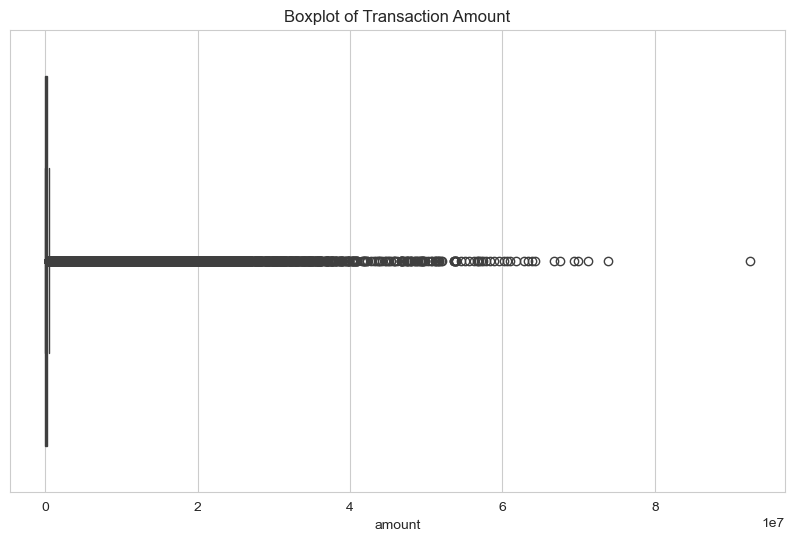

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['amount'])
plt.title('Boxplot of Transaction Amount')
plt.show()

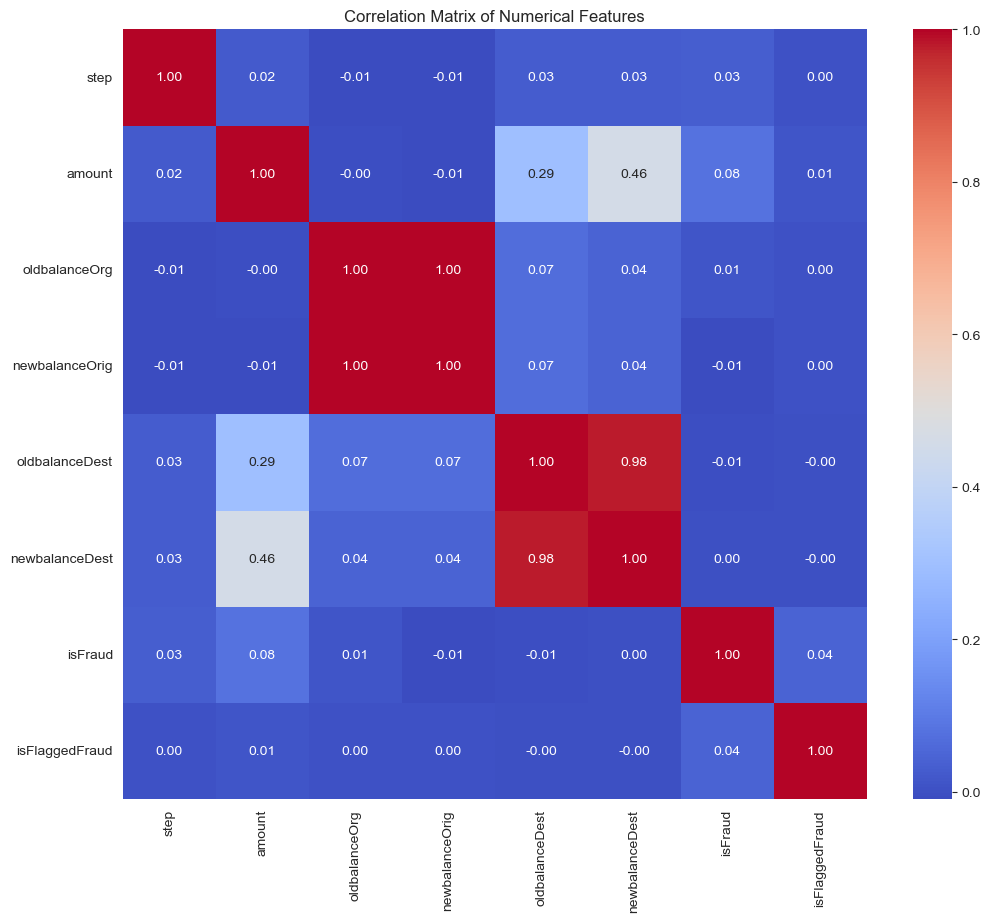

In [15]:
# Select only numerical columns for the correlation matrix
numerical_df = df.select_dtypes(include=np.number)
corr_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [16]:
# Drop irrelevant columns
df_model = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

# One-hot encode the 'type' column
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

# --- FIX: Drop rows where 'isFraud' is NaN BEFORE splitting ---
# Let's first check how many missing values there are
print(f"Missing values in 'isFraud' before dropping: {df_model['isFraud'].isnull().sum()}")

# Now, drop them
df_model.dropna(subset=['isFraud'], inplace=True)

# Verify that they are gone
print(f"Missing values in 'isFraud' after dropping: {df_model['isFraud'].isnull().sum()}")
# -------------------------------------------------------------

# Separate features (X) and target (y)
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

# Ensure the target variable is of integer type, which is good practice for classification
y = y.astype(int)

# Split the data
# Now this line will work without any errors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the datasets to verify
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Missing values in 'isFraud' before dropping: 0
Missing values in 'isFraud' after dropping: 0
Shape of X_train: (5090096, 10)
Shape of X_test: (1272524, 10)
Shape of y_train: (5090096,)
Shape of y_test: (1272524,)


In [17]:
# Import the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the model. 
# class_weight='balanced' is crucial for imbalanced datasets like this one.
# It adjusts weights inversely proportional to class frequencies.
# n_jobs=-1 uses all available CPU cores to speed up training.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

# Train the model on the training data
print("Training the Random Forest model... (This may take a few minutes)")
rf_model.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model... (This may take a few minutes)
Model training complete.


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.78      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

--- Confusion Matrix ---


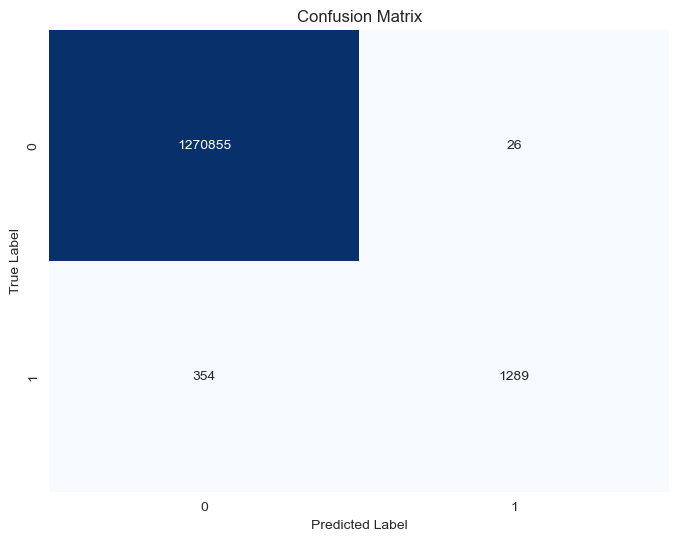


ROC-AUC Score: 0.9956


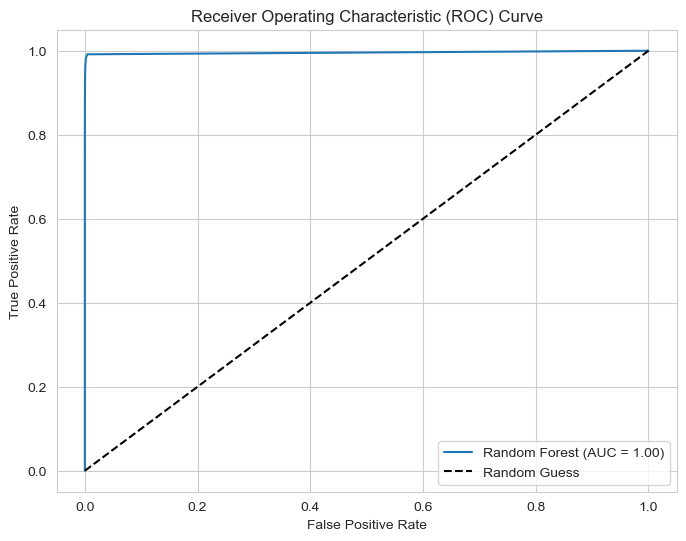

In [18]:
# Import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (isFraud=1)

# 1. Classification Report
# This gives you precision, recall, and f1-score.
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix
# This shows True Positives, False Positives, True Negatives, and False Negatives.
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 3. ROC AUC Score and Curve
# This shows the model's ability to distinguish between classes.
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

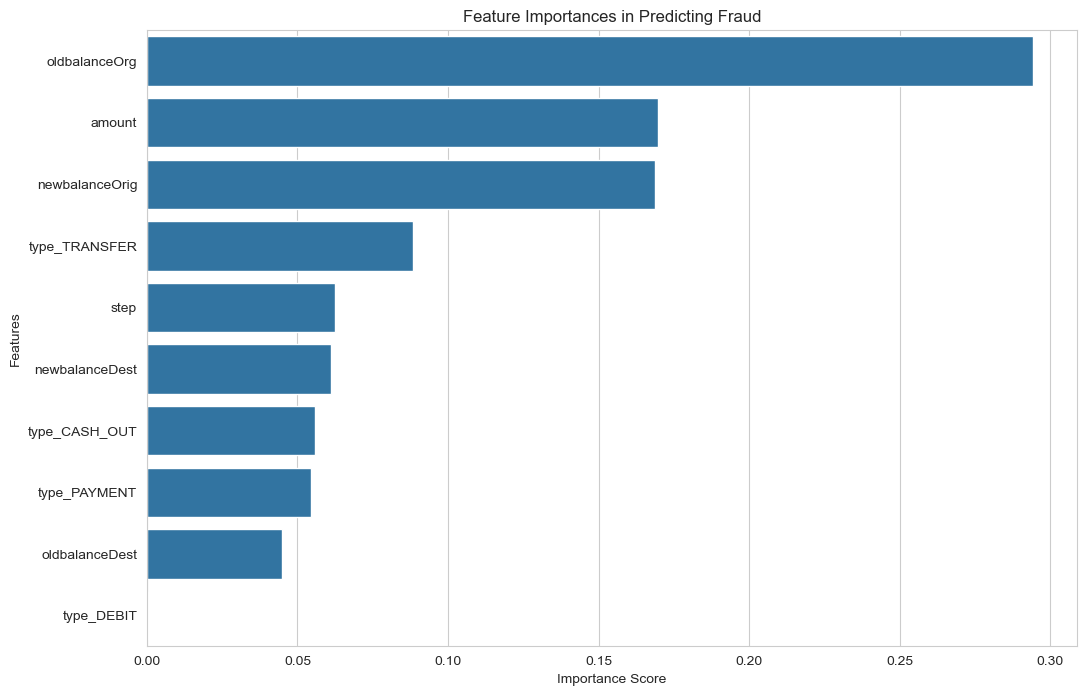

In [19]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances in Predicting Fraud')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()